In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
pd.set_option('display.max_columns', None)
import time
import warnings
warnings.filterwarnings("ignore")

import torch
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [2]:
dataset_name = 'compas'

# Load Datasets

In [3]:
# LOAD Dataset
from exp.data_loader import load_tabular_data

X_train, X_test, Y_train, Y_test, df = load_tabular_data(dataset_name)

# Black Box Training

In [4]:
# load Black Boxes

# XGB
from xgboost import XGBClassifier
clf_xgb = XGBClassifier(n_estimators=60, reg_lambda=3, use_label_encoder=False, eval_metric='logloss')
clf_xgb.fit(X_train, Y_train)
clf_xgb.save_model(f'./blackboxes/{dataset_name}_xgboost')
clf_xgb.load_model(f'./blackboxes/{dataset_name}_xgboost')
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)
print('XGB')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#RF
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(random_state=random_seed)
clf_rf.fit(X_train, Y_train)
pickle.dump(clf_rf,open(f'./blackboxes/{dataset_name}_rf.p','wb'))
clf_rf = pickle.load(open(f'./blackboxes/{dataset_name}_rf.p','rb'))
y_train_pred = clf_rf.predict(X_train)
y_test_pred = clf_rf.predict(X_test)
print('RF')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

#SVC
from sklearn.svm import SVC
clf_svc = SVC(gamma='auto', probability=True)
clf_svc.fit(X_train, Y_train)
pickle.dump(clf_svc,open(f'./blackboxes/{dataset_name}_svc.p','wb'))
clf_svc = pickle.load(open(f'./blackboxes/{dataset_name}_svc.p','rb'))
y_train_pred = clf_svc.predict(X_train)
y_test_pred = clf_svc.predict(X_test)
print('SVC')
print('train acc:',np.mean(np.round(y_train_pred)==Y_train))
print('test acc:',np.mean(np.round(y_test_pred)==Y_test))

# NN
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
class FFNN(pl.LightningModule):
    def __init__(self, input_shape):
        super(FFNN,self).__init__()
        self.fc1 = nn.Linear(input_shape,10)
        self.fc2 = nn.Linear(10,5)
        self.out = nn.Linear(5,1)
        self.lr = 1e-3
        self.loss = nn.BCEWithLogitsLoss()
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)
    def predict(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.sigmoid(self.out(x))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("train_loss", loss, on_epoch=True)
        return loss
    def validation_step(self, valid_batch, batch_idx):
        x, y = valid_batch
        logits = self.forward(x)
        loss = self.loss(logits,y)
        self.log("test_loss", loss, on_epoch=True)
clf_nn = FFNN(X_train.shape[1])
# -------- training ----------
class Data(pl.LightningDataModule):
    def prepare_data(self):      
        self.train_data = TensorDataset(torch.tensor(X_train.values).float(),torch.tensor(Y_train.values).reshape(-1,1).float())
        self.test_data = TensorDataset(torch.tensor(X_test.values).float(),torch.tensor(Y_test.values).reshape(-1,1).float())

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=1024, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_data, batch_size=1024, shuffle=False)
data = Data()
logger = TensorBoardLogger("NN_logs", name=f"NN_{dataset_name}", version=0)
es = EarlyStopping(monitor="train_loss", mode="min")
class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True)
        return bar
bar = LitProgressBar()
trainer = pl.Trainer(logger=logger, max_epochs=5000, callbacks=[es,bar], enable_checkpointing=False)
trainer.fit(clf_nn,data)
torch.save(clf_nn.state_dict(), f'./blackboxes/{dataset_name}_tf_nn.pt')
# ----------------------
clf_nn.load_state_dict(torch.load(f'./blackboxes/{dataset_name}_tf_nn.pt'))        
clf_nn.trainable = False
from sklearn.metrics import accuracy_score
with torch.no_grad():
       clf_nn.eval()
       print('NN')
       print('train_acc: ',accuracy_score(np.round(clf_nn.predict(torch.tensor(X_train.values).float()).detach().numpy()),Y_train))
       print('test_acc: ',accuracy_score(np.round(clf_nn.predict(torch.tensor(X_test.values).float()).detach().numpy()),Y_test))

XGB
train acc: 0.9874392220421394
test acc: 0.9530364372469635
RF
train acc: 1.0
test acc: 0.9489878542510122
SVC
train acc: 0.9325364667747164
test acc: 0.934412955465587


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type              | Params
-------------------------------------------
0 | fc1  | Linear            | 340   
1 | fc2  | Linear            | 55    
2 | out  | Linear            | 6     
3 | loss | BCEWithLogitsLoss | 0     
-------------------------------------------
401       Trainable params
0         Non-trainable params
401       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

NN
train_acc:  0.9313209076175041
test_acc:  0.9408906882591093


In [6]:
black_box = 'xgb'

if black_box=='xgb':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_xgb.predict_proba(x)[:,1].ravel()
        else: return clf_xgb.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='rf':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_rf.predict_proba(x)[:,1].ravel()
        else: return clf_rf.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='svc':
    def predict(x, return_proba=False):
        if return_proba:
            return clf_svc.predict_proba(x)[:,1].ravel()
        else: return clf_svc.predict(x).ravel().ravel()
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)
elif black_box=='nn':
    def predict(x, return_proba=False):
        clf_nn.eval()
        if return_proba:
            with torch.no_grad():
                return clf_nn.predict(torch.tensor(x.values).float()).detach().numpy()
        else: return np.round(clf_nn.predict(torch.tensor(x.values).float()).detach().numpy())
    y_test_pred = predict(X_test, return_proba=True)
    y_train_pred = predict(X_train, return_proba=True)

# Latent Space Training

In [7]:
X_train_latent = np.hstack((X_train,y_train_pred.reshape(-1,1)))
X_test_latent = np.hstack((X_test,y_test_pred.reshape(-1,1)))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Latent Space
latent_dim = 10
batch_size = 1024
sigma = 1
max_epochs = 1000
early_stopping = 3
learning_rate = 1e-3

if dataset_name == 'adult':
    idx_cat = [2,3,4,5,6]
elif dataset_name == 'fico':
    idx_cat = None
elif dataset_name == 'german':
    idx_cat = np.arange(3,71,1).tolist()
elif dataset_name == 'compas':
    idx_cat = list(range(13,33,1))

similarity_KLD = torch.nn.KLDivLoss(reduction='batchmean')
def compute_similarity_Z(Z, sigma):
    D = 1 - F.cosine_similarity(Z[:, None, :], Z[None, :, :], dim=-1)
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def compute_similarity_X(X, sigma, idx_cat=None):
    D_class = torch.cdist(X[:,-1].reshape(-1,1),X[:,-1].reshape(-1,1))
    X = X[:, :-1]
    if idx_cat:
        X_cat = X[:, idx_cat]
        X_cont = X[:, np.delete(range(X.shape[1]),idx_cat)]
        h = X_cat.shape[1]
        m = X.shape[1]
        D_cont = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1)
        D_cat = torch.cdist(X_cat, X_cat, p=0)/h
        D = h/m * D_cat + ((m-h)/m) * D_cont + D_class
    else:
        D_features = 1 - F.cosine_similarity(X[:, None, :], X[None, :, :], dim=-1) 
        D = D_features + D_class
    M = torch.exp((-D**2)/(2*sigma**2))
    return M / (torch.ones([M.shape[0],M.shape[1]])*(torch.sum(M, axis = 0)-1)).transpose(0,1)
def loss_function(X, Z, idx_cat, sigma=1):
    Sx = compute_similarity_X(X, sigma, idx_cat)
    Sz = compute_similarity_Z(Z, sigma)
    loss = similarity_KLD(torch.log(Sx), Sz)
    return loss

class LinearModel(nn.Module):
    def __init__(self, input_shape, latent_dim):
        super(LinearModel, self).__init__()
        # encoding components
        self.fc1 = nn.Linear(input_shape, latent_dim)
    def encode(self, x):
        x = self.fc1(x)
        return x
    def forward(self, x):
        z = self.encode(x)
        return z

# Create Model
model = LinearModel(X_train_latent.shape[1], latent_dim=latent_dim)

In [10]:
train_dataset = TensorDataset(torch.tensor(X_train_latent).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataset = TensorDataset(torch.tensor(X_test_latent).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

def check_and_clear(dir_name):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    else:
        os.system('rm -r ' + dir_name)
        os.mkdir(dir_name)
check_and_clear('./models/weights')

model_params = list(model.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)
# record training process
epoch_train_losses = []
epoch_test_losses = []
#validation parameters
epoch = 1
best = np.inf
# progress bar
pbar = tqdm(bar_format="{postfix[0]} {postfix[1][value]:03d} {postfix[2]} {postfix[3][value]:.5f} {postfix[4]} {postfix[5][value]:.5f} {postfix[6]} {postfix[7][value]:d}",
            postfix=["Epoch:", {'value':0}, "Train Sim Loss", {'value':0}, "Test Sim Loss", {'value':0}, "Early Stopping", {"value":0}])

# start training
while epoch <= max_epochs:
    # ------- TRAIN ------- #
    # set model as training mode
    model.train()
    batch_loss = []
    for batch, (X_batch,) in enumerate(train_loader):
        optimizer.zero_grad()
        Z_batch = model(X_batch)  #
        loss  = loss_function(X_batch, Z_batch, idx_cat, sigma) 
        loss.backward()
        optimizer.step()
        batch_loss.append(loss.item())
    # save result
    epoch_train_losses.append(np.mean(batch_loss))
    pbar.postfix[3]["value"] = np.mean(batch_loss)

    # -------- VALIDATION --------
    # set model as testing mode
    model.eval()
    batch_loss = []
    with torch.no_grad():
        for batch, (X_batch,) in enumerate(test_loader):
            Z_batch = model(X_batch)
            loss = loss_function(X_batch, Z_batch, idx_cat, sigma)
            batch_loss.append(loss.item())

    # save information
    epoch_test_losses.append(np.mean(batch_loss))
    pbar.postfix[5]["value"] = np.mean(batch_loss)
    pbar.postfix[1]["value"] = epoch
    # Early Stopping
    if epoch_test_losses[-1] < best:
        wait = 0
        best = epoch_test_losses[-1]
        best_epoch = epoch
        torch.save(model.state_dict(), f'./models/weights/LinearTransparent_{dataset_name}.pt')
    else:
        wait += 1
    pbar.postfix[7]["value"] = wait
    if wait == early_stopping:
        break    
    epoch += 1
    pbar.update()

model.load_state_dict(torch.load(f'./models/weights/LinearTransparent_{dataset_name}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()
torch.save(model.state_dict(), f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt')

Epoch: 000 Train Sim Loss 0.00000 Test Sim Loss 0.00000 Early Stopping 0

In [11]:
model.load_state_dict(torch.load(f'./models/{dataset_name}_latent_{black_box}_{latent_dim}.pt'))
with torch.no_grad():
    model.eval()
    Z_train = model(torch.tensor(X_train_latent).float()).cpu().detach().numpy()
    Z_test = model(torch.tensor(X_test_latent).float()).cpu().detach().numpy()

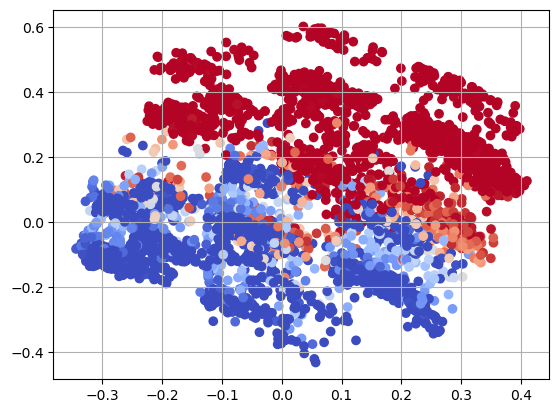

In [13]:
plt.scatter(Z_train[:,2], Z_train[:,1], c=y_train_pred, cmap='coolwarm')
plt.grid()

# Prototypes

In [ ]:
# from sklearn.cluster import SpectralClustering, KMeans

# Z_train_0 = Z_train[y_train_pred==0]
# Z_train_1 = Z_train[y_train_pred==1]

# # number of clusters 
# n = 10

# # n//(1/0.7) adjust for proportion of data
# clustering_0 = SpectralClustering(n_clusters=int(n//(1/(y_train_bb==0/len(y_train_bb)))),assign_labels='discretize').fit(Z_train_0)
# clustering_1 = SpectralClustering(n_clusters=int(n-n//(1/(y_train_bb==0/len(y_train_bb)))),assign_labels='discretize').fit(Z_train_1)

# centers = []
# for i in range(int(n//(1/(y_train_bb==0/len(y_train_bb))))):
#     centers.append(np.mean(Z_train_0[clustering_0.labels_==i],axis=0))
# for i in range(int(n-n//(1/(y_train_bb==0/len(y_train_bb))))):
#     centers.append(np.mean(Z_train_1[clustering_1.labels_==i],axis=0))
# centers = np.stack(centers)

# from scipy.spatial.distance import cdist
# idx = np.argmin(cdist(centers,Z_train),axis=1)
# proto_latent_clustering = pd.DataFrame(X_train_latent[idx,:-1],columns=X_train.columns)

# proto_pred = predict(proto_latent_clustering)
# print('perc positive proto: ', np.mean(proto_pred))

# from scipy.spatial.distance import cdist
# knn_1 = np.argmin(cdist(proto_latent_clustering.values, X_test_latent[:,:-1]),axis=0)
# d = {}
# for i in range(n):
#     d[i]=proto_pred[i]
# knn_1 = [d[x] for x in knn_1]
# print('accuracy 1-KNN:',accuracy_score(knn_1,y_test_bb))

# print('avg_distance:',np.mean(cdist(proto_latent_clustering.values,proto_latent_clustering.values)))

# Counterfactuals

In [14]:
w = model.fc1.weight.detach().numpy()
b = model.fc1.bias.detach().numpy()
y_contrib = model.fc1.weight.detach().numpy()[:,-1]

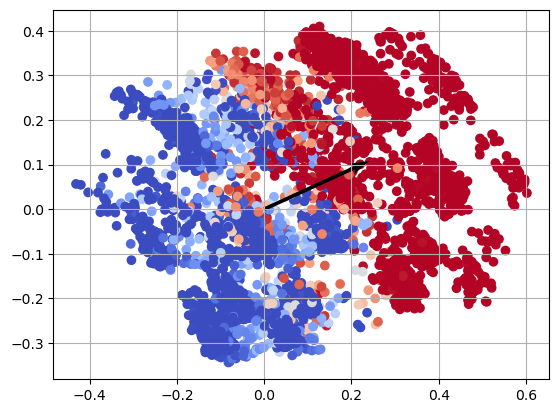

In [30]:
plt.scatter(Z_train[:,1], Z_train[:,2], c=y_train_pred, cmap='coolwarm')
plt.quiver(0,0,y_contrib[1],y_contrib[2],angles='xy', scale_units='xy', scale=1)
plt.grid()

In [34]:
def compute_cf(q, indexes):
    q_pred = predict(q,return_proba=True)
    q_cf = q.copy()
    q_cf_preds = []
    q_cf_preds.append(float(predict(q_cf,return_proba=True)))
    q_cf['prediction'] = q_pred
    if q_pred > 0.5:
        m = -0.1
    else:
        m = +0.1
    while np.round(q_pred) == np.round(q_cf_preds[-1]):
        # compute the vector to apply
        v = (model(torch.tensor(q_cf.values).float()).detach().numpy()+m*y_contrib).ravel()
        # compute the changes delta in the input space
        c_l = [v[l] - np.sum(q_cf.values*w[l,:]) - b[l] for l in range(latent_dim)]
        M = []
        for l in range(latent_dim):
            M.append([np.sum(w[k,indexes]*w[l,indexes]) for k in range(latent_dim)])
        M = np.vstack(M)
        lambda_k = np.linalg.solve(M, c_l)
        delta_i = [np.sum(lambda_k*w[:,i]) for i in indexes]
        q_cf.iloc[:,indexes] += delta_i
        #q_cf = np.clip(q_cf,-1,1)
        # check changes or null effects in the prediction
        if float(predict(q_cf.iloc[:,:-1],return_proba=True)) in q_cf_preds:
            return q_cf.iloc[:,:-1]
        q_cf_preds.append(float(predict(q_cf.iloc[:,:-1],return_proba=True)))
        q_cf.iloc[:,-1] = q_cf_preds[-1]
    return q_cf.iloc[:,:-1]

In [35]:
from itertools import combinations
from scipy.spatial.distance import cdist

# number of features to change
k = 6

d_dist = []
d_impl = []
d_count = []
d_adv = []
num = []
div_dist = []
div_count = []

idx = 0
# for idx in tqdm(range(n)):

q = X_test.iloc[idx:idx+1,:].copy()
q_pred = predict(q,return_proba=False)
q_cfs = []
l_i = []
l_f = []

for indexes in list(combinations(list(range(X_train.shape[1])),1)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf,return_proba=True)
    if q_pred:
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
    else:
        if q_cf_pred>0.5:
            q_cfs.append(q_cf) 

for indexes in list(combinations(list(range(X_train.shape[1])),2)):    
    q_cf = compute_cf(q, list(indexes))
    q_cf_pred = predict(q_cf,return_proba=True)
    if q_pred:
        if q_cf_pred<0.5:
            q_cfs.append(q_cf)
    else:
        if q_cf_pred>0.5:
            q_cfs.append(q_cf) 
    l_i.append([list(indexes),q_cf_pred])
r = np.argsort(np.stack(np.array(l_i,dtype=object)[:,1]).ravel())[-10:]
l_i = np.array(l_i,dtype=object)[r,0]

while len(l_i[0])<k:
    for e in l_i:
        for i in list(np.delete(range(X_train.shape[1]),e)):
            q_cf = compute_cf(q, e+[i])
            q_cf_pred = predict(q_cf,return_proba=True)
            if q_pred:
                if q_cf_pred<0.5:
                    q_cfs.append(q_cf)
            else:
                if q_cf_pred>0.5:
                    q_cfs.append(q_cf) 
            l_f.append([e+[i],q_cf_pred])
    r = np.argsort(np.stack(np.array(l_f,dtype=object)[:,1]).ravel())[-10:]
    l_f = np.array(l_f,dtype=object)[r,0]
    l_i = l_f.copy()
    l_f = []

In [42]:
pd.concat(q_cfs)

,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,decile_score.1,v_decile_score,priors_count.1,start,end,Female,Male,African-American,Asian,Caucasian,Hispanic,Native American,Other,charge_degree_F,charge_degree_M,score_text_high,score_text_low,score_text_medium,v_score_text_high,v_score_text_low,v_score_text_medium,event_0,event_1,not_violent_recid,violent_recid
6417,-0.051282,-2.620999,-0.111111,-1.0,-1.0,0.421053,-0.033333,-0.999789,-0.111111,-1.0,0.421053,-0.997866,-0.859887,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,1.618051,-0.033333,-0.999789,-0.111111,-1.0,0.421053,-0.997866,-1.391007,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,-0.033333,-0.999789,8.610050,-1.0,0.421053,-0.997866,-12.793874,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,-0.033333,-0.999789,-0.111111,-1.0,-2.157564,-0.997866,-2.010695,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,-0.033333,-0.999789,-0.111111,-1.0,0.421053,3.164927,-0.790758,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,-0.865238,-0.999789,-0.111111,-1.0,0.421053,-0.754997,-0.377572,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.209966,0.000000,1.000000,0.0,1.0,-0.111854,0.236533,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,12.620198,-0.999789,-0.111111,-1.0,0.421053,-0.838125,-0.755078,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,-0.255471,1.000000,0.0,1.0,0.332240,1.235171,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,5.158829,-0.999789,-0.111111,-1.0,0.421053,-0.839125,-0.435813,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.879405,0.0,1.0,-0.425643,0.257566,0.0,1.000000,0.000000
6417,-0.051282,-1.000000,-0.111111,-1.0,-1.0,0.421053,-0.446181,-0.999789,-0.111111,-1.0,0.421053,-1.142438,-0.091060,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.000000,0.0,1.0,-0.545993,0.231292,0.0,1.178963,0.000000
